In [1]:
import numpy as np 
import pandas as pd 
import os
import sys
from tqdm import tqdm
import pathlib

import matplotlib.pyplot as plt
%matplotlib inline
import cv2

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.metrics import fbeta_score

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input/planets-dataset'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [3]:
!ls /kaggle/input/planets-dataset

planet	test-jpg-additional


In [4]:
train_df = pd.read_csv("/kaggle/input/planets-dataset/planet/planet/train_classes.csv")
test_df = pd.read_csv("/kaggle/input/planets-dataset/planet/planet/sample_submission.csv")

# Data Exploration

In [5]:
train_classes = train_df[:]['tags']

no_classes = len(train_classes.unique())
print(f'Given {len(train_classes)} samples, there are {no_classes} unique classes.', '\n')

train_df.head()

Given 40479 samples, there are 449 unique classes. 



,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
# Split the tags column to get the unique labels
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in train_df['tags'].values])))

# Mapping the label value counts
label_map = {l: i for i, l in enumerate(labels)}
print(f'labels = {labels},\n length = {len(labels)}', '\n')

print(f'label_map = {label_map},\n length = {len(label_map)}')

labels = ['partly_cloudy', 'blow_down', 'artisinal_mine', 'water', 'clear', 'agriculture', 'bare_ground', 'primary', 'haze', 'blooming', 'cloudy', 'conventional_mine', 'cultivation', 'road', 'slash_burn', 'selective_logging', 'habitation'],
 length = 17 

label_map = {'partly_cloudy': 0, 'blow_down': 1, 'artisinal_mine': 2, 'water': 3, 'clear': 4, 'agriculture': 5, 'bare_ground': 6, 'primary': 7, 'haze': 8, 'blooming': 9, 'cloudy': 10, 'conventional_mine': 11, 'cultivation': 12, 'road': 13, 'slash_burn': 14, 'selective_logging': 15, 'habitation': 16},
 length = 17


<BarContainer object of 17 artists>

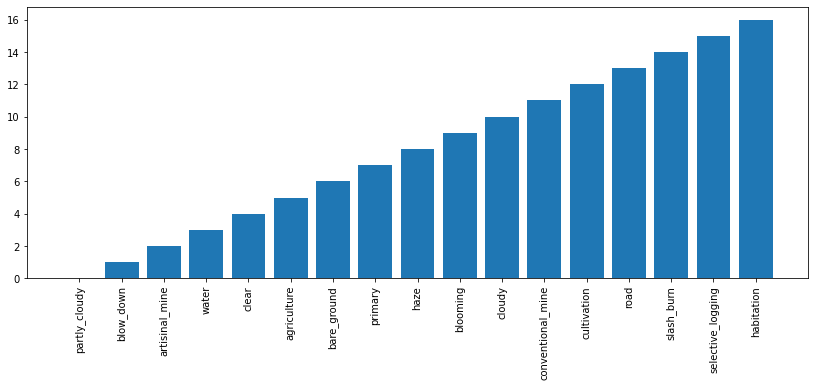

In [7]:
keys = list(label_map.keys())
values = list(label_map.values())
labels_df = pd.DataFrame({'labels':keys, 'freq':values})
labels_df = labels_df.sort_values('freq')

plt.rcParams['figure.figsize']=(14,5)
plt.xticks(rotation=90)
plt.bar('labels', 'freq', data=labels_df)

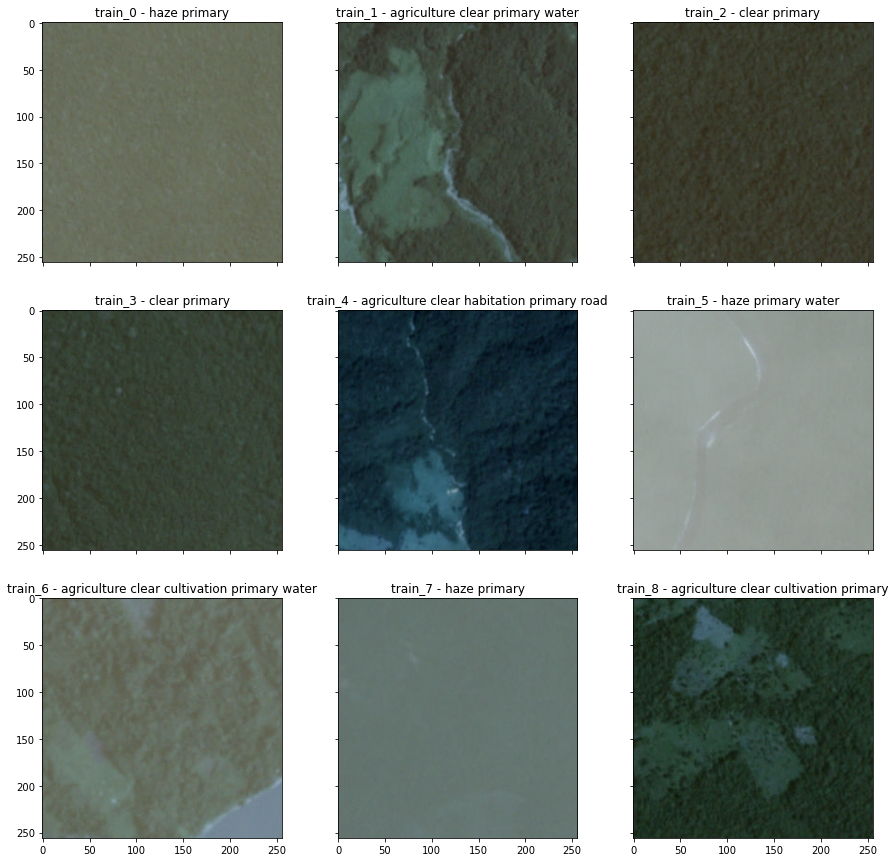

In [8]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(15, 15))
i = 0
for f, tags in train_df[:9].values:
    img = cv2.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(img)
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, tags))
  
    i += 1
    
plt.show()

Since there two file formats (.jpg and .csv) for the train and test sets, after loading the csv, the jpegs will be loaded through their paths, to ensure that both file types are of the same size.

In [9]:
# Load the train-jpg file path

train_img_dir = pathlib.Path('/kaggle/input/planets-dataset/planet/planet/train-jpg')

train_img_path = sorted(list(train_img_dir.glob('*.jpg')))

train_img_count = len(train_img_path)
print(train_img_count)

40479


In [10]:
# first test jpg file path
test_img_dir = pathlib.Path('/kaggle/input/planets-dataset/planet/planet/test-jpg')

test_img_path = sorted(list(test_img_dir.glob('*.jpg')))

test_img_count = len(test_img_path)
print(test_img_count)

40669


In [11]:
# second test jpg file path

test_add_img_dir = pathlib.Path('/kaggle/input/planets-dataset/test-jpg-additional')

test_add_img_path = sorted(list(test_add_img_dir.glob('*/*.jpg')))

test_add_img_count = len(test_add_img_path)
print(test_add_img_count)

20522


In [12]:
# Ensure the number of jpg images are equal to the number of samples in the csv file for each data set

# train
assert len(train_img_path) == len(train_df)

# test
assert len(test_img_path)+len(test_add_img_path) == len(test_df)

# Training a Model

In [13]:
input_size = 64
input_channels = 3

batch_size = 64

In [14]:
x_train = []
y_train = []

for f, tags in tqdm(train_df.values, miniters=1000):
    img = cv2.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    img = cv2.resize(img, (input_size, input_size))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(img)
    y_train.append(targets)
        
x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.uint8)

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [01:58<00:00, 342.10it/s]


(40479, 64, 64, 3)
(40479, 17)


In [15]:
x_test = []

test_jpg_dir = '/kaggle/input/planets-dataset/planet/planet/test-jpg'
test_image_names = os.listdir(test_jpg_dir)

n_test = len(test_image_names)
test_classes = test_df.iloc[:n_test, :]
add_classes = test_df.iloc[n_test:, :]

test_jpg_add_dir = '/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional'
test_add_image_names = os.listdir(test_jpg_add_dir)

for img_name, _ in tqdm(test_classes.values, miniters=1000):
    img = cv2.imread(test_jpg_dir + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))
    
for img_name, _ in tqdm(add_classes.values, miniters=1000):
    img = cv2.imread(test_jpg_add_dir + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))

x_test = np.array(x_test, np.float32)
print(x_test.shape)

100%|██████████| 20522/20522 [01:00<00:00, 340.16it/s]


(61191, 64, 64, 3)


In [16]:
# split the train data into train and validation data sets
X_train = x_train[ :33000]
Y_train = y_train[ :33000]

X_valid = x_train[33000: ]
Y_valid = y_train[33000: ]

> **The Model Architecture**

In [17]:
base_model = VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=(input_size, input_size, input_channels))

model = Sequential()
model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))

model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(17, activation='sigmoid'))

58892288/58889256 [==============================] - 0s 0us/step


In [18]:
from keras.optimizers import SGD
opt  = SGD(lr=0.01)

model.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])
    
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0),
                ModelCheckpoint(filepath='weights/best_weights',
                                 save_best_only=True,
                                 save_weights_only=True)]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 64, 64, 3)         12        
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 17)                34833     
Total params: 14,749,533
Trainable params: 14,749,527
Non-trainable params: 6
_________________________________________________________________


In [19]:
history = model.fit(x=X_train, y=Y_train, validation_data=(X_valid, Y_valid),
                  batch_size=batch_size,verbose=2, epochs=15,callbacks=callbacks,shuffle=True)

Epoch 1/15
516/516 - 26s - loss: 0.1842 - accuracy: 0.1617 - val_loss: 0.1331 - val_accuracy: 0.1375
Epoch 2/15
516/516 - 24s - loss: 0.1405 - accuracy: 0.2066 - val_loss: 0.1240 - val_accuracy: 0.1515
Epoch 3/15
516/516 - 24s - loss: 0.1291 - accuracy: 0.2165 - val_loss: 0.1154 - val_accuracy: 0.1798
Epoch 4/15
516/516 - 24s - loss: 0.1223 - accuracy: 0.2300 - val_loss: 0.1122 - val_accuracy: 0.2198
Epoch 5/15
516/516 - 24s - loss: 0.1176 - accuracy: 0.2345 - val_loss: 0.1099 - val_accuracy: 0.1824
Epoch 6/15
516/516 - 24s - loss: 0.1136 - accuracy: 0.2290 - val_loss: 0.1111 - val_accuracy: 0.1642
Epoch 7/15
516/516 - 24s - loss: 0.1114 - accuracy: 0.2277 - val_loss: 0.1055 - val_accuracy: 0.2121
Epoch 8/15
516/516 - 24s - loss: 0.1093 - accuracy: 0.2345 - val_loss: 0.1045 - val_accuracy: 0.1968
Epoch 9/15
516/516 - 24s - loss: 0.1072 - accuracy: 0.2383 - val_loss: 0.1060 - val_accuracy: 0.2090
Epoch 10/15
516/516 - 24s - loss: 0.1051 - accuracy: 0.2335 - val_loss: 0.1017 - val_accura

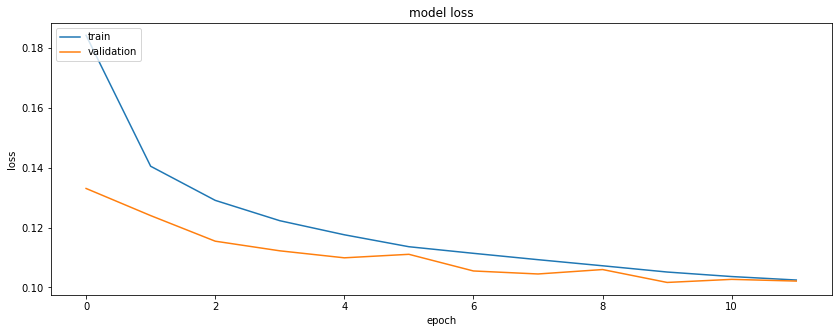

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

> **Model Evaluation**

In [21]:
p_valid = model.predict(X_valid, batch_size = batch_size, verbose=1)

print(fbeta_score(Y_valid, np.array(p_valid) > 0.18, beta=2, average='samples'))

117/117 [==============================] - 2s 13ms/step
0.9133102211375658


# Model Prediction on Test data

In [22]:
y_pred = []
p_test = model.predict(x_test, batch_size=batch_size, verbose=2)
y_pred.append(p_test)

957/957 - 13s


In [23]:
result = np.array(y_pred[0])
for i in range(1, len(y_pred)):
    result += np.array(y_pred[i])
result = pd.DataFrame(result, columns=labels)

In [24]:
# Translating the probability predictions to the unique labels
preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.loc[[i]]
    a = a.apply(lambda x: x>0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [02:27<00:00, 414.23it/s]


In [25]:
# Replacing the tags columns with the predicted labels
test_df['tags'] = preds
test_df.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear primary
4,test_4,partly_cloudy primary cloudy


In [26]:
# Converting the dataframe to a csv file for submission
test_df.to_csv('amazon_sample_submission.csv', index=False)

In [ ]:
# Private Score: 0.91055, Public Score: 0.91183